# Energy demand EDA

### Initial settings

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os,random, math, psutil, pickle 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import pandas as pd
import seaborn as sns
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

sns.set()
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)



from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

### Mounting google drive

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading the pickle file

In [5]:
train = pd.read_pickle('clean_data')

In [51]:
holidays = pd.read_csv('UKholidays.csv')
holidays.head()

,date,name,bank_holiday
0,1/1/2009,New Year's Day,1
1,1/25/2009,Robert Burns Night (Burns Night),0
2,1/27/2009,Holocaust Memorial Day,0
3,2/14/2009,Valentines Day,0
4,2/24/2009,Shrove Tuesday (Pancake Day),0


### Data description

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411298 entries, 0 to 411297
Data columns (total 3 columns):
meter_reading    359652 non-null float64
timestamp        411298 non-null datetime64[ns]
site_id          411298 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.8+ MB


In [29]:
train.head(10)

,meter_reading,timestamp,site_id
0,0.28658,2015-02-15 00:00:00,A01
1,0.28658,2015-02-15 00:05:00,A01
2,0.28520,2015-02-15 00:10:00,A01
3,0.28658,2015-02-15 00:15:00,A01
4,0.23874,2015-02-15 00:20:00,A01
5,0.20953,2015-02-15 00:25:00,A01
6,0.33074,2015-02-15 00:30:00,A01
7,0.15065,2015-02-15 00:35:00,A01
8,0.17618,2015-02-15 00:40:00,A01
9,0.26910,2015-02-15 00:45:00,A01


In [30]:
train.tail(10)

,meter_reading,timestamp,site_id
411288,0.11523,2015-03-28 23:15:00,F27
411289,0.28658,2015-03-28 23:20:00,F27
411290,1.31767,2015-03-28 23:25:00,F27
411291,2.05114,2015-03-28 23:30:00,F27
411292,0.15985,2015-03-28 23:35:00,F27
411293,0.23414,2015-03-28 23:40:00,F27
411294,0.15985,2015-03-28 23:45:00,F27
411295,0.33304,2015-03-28 23:50:00,F27
411296,1.34320,2015-03-28 23:55:00,F27
411297,1.34458,2015-03-29 00:00:00,F27


In [31]:
train.describe()

,meter_reading
count,359652.000000
mean,0.447514
std,0.777284
min,0.000000
25%,0.102580
50%,0.196880
75%,0.371450
max,13.269620


In [9]:
train.dtypes.value_counts()

object            1
datetime64[ns]    1
float64           1
dtype: int64

### Converting the object data type to string for site_id column

In [32]:
train['site_id'] = train['site_id'].astype('str')

train.site_id.unique()

array(['A01', 'A02', 'A03', 'A04', 'A07', 'A11', 'A13', 'A14', 'A18_app',
       'B02', 'B08', 'C02', 'C05', 'C06', 'C14', 'C16', 'C19', 'C24',
       'C26', 'C32', 'C33', 'C35', 'C40', 'C42', 'D01', 'D05', 'D08',
       'D10', 'D15', 'D16', 'D20a', 'D25b', 'F20', 'F27'], dtype=object)

### Checking missing data for train

In [33]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head()

,Total,Percent
meter_reading,51646,12.556832
site_id,0,0.000000
timestamp,0,0.000000


### Daily and hourly demand for each biulding

IndexError: index 2 is out of bounds for axis 0 with size 2

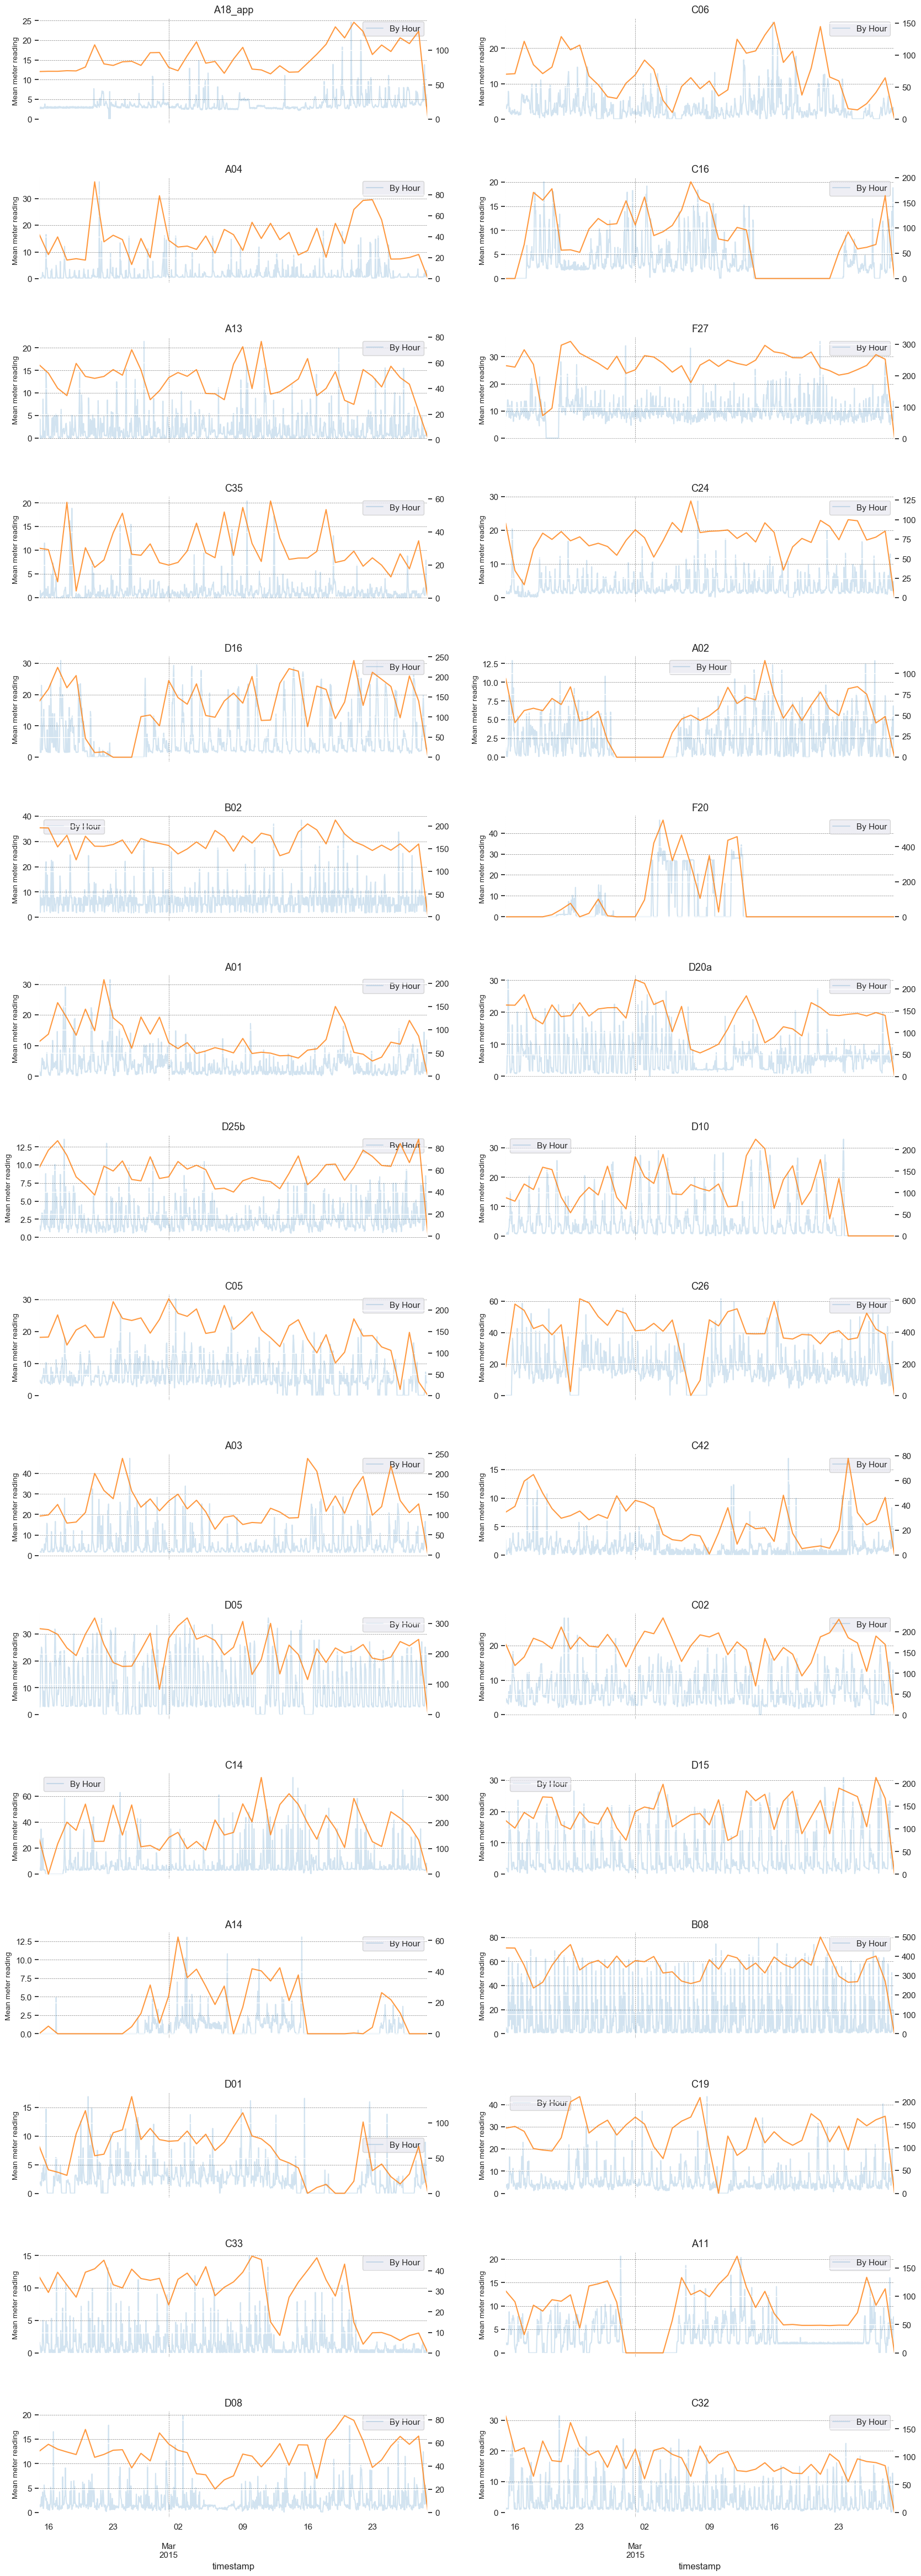

In [34]:
fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(20, 60), dpi=100)
#fig.patch.set_facecolor('xkcd:mint green')
for i, id in enumerate(train['site_id'].value_counts().index.to_list()):
    try:
        
        train[train['site_id'] == id][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').sum()['meter_reading'].plot(ax=axes[i%16][i//16], alpha=0.2, label='By Hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=10);
        train[train['site_id'] == id][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').sum()['meter_reading'].plot(ax=axes[i%16][i//16], alpha=0.8, label='By day', color='tab:orange', secondary_y=True).set_xlabel('');
        axes[i%16][i//16].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
        axes[i%16][i//16].patch.set_facecolor('white')
        axes[i%16][i//16].legend();
    except TypeError:
        pass
    axes[i%16][i//16].set_title(id, fontsize=13);
    plt.subplots_adjust(hspace=0.5)


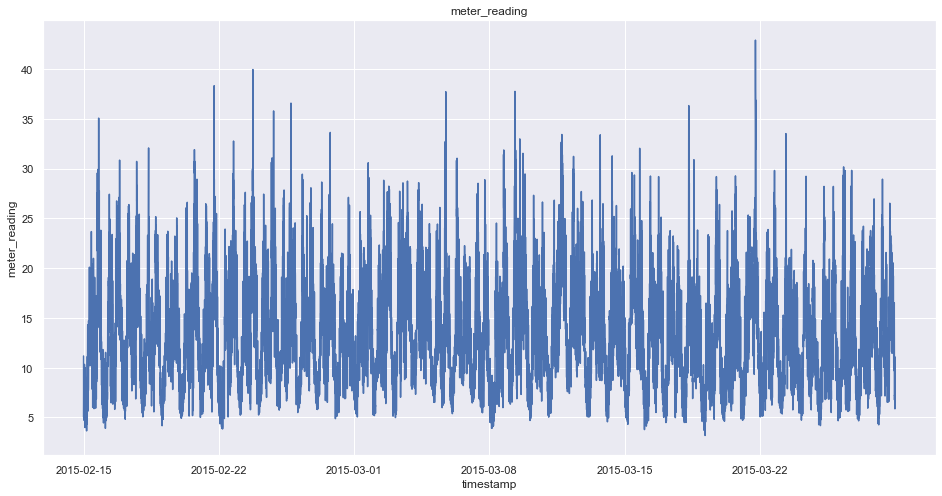

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts=train.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

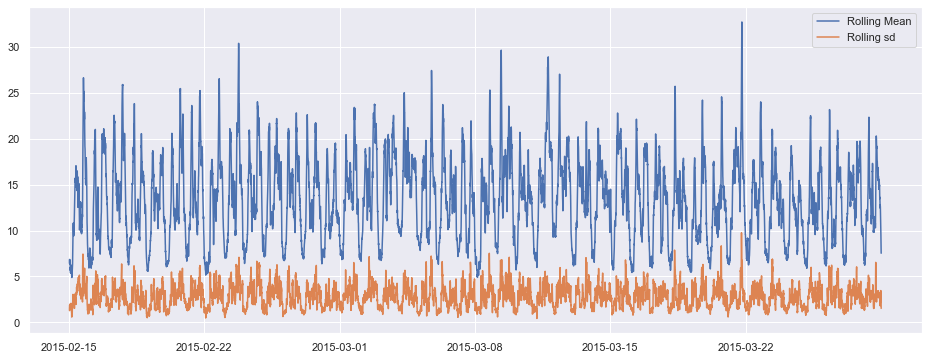

In [13]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

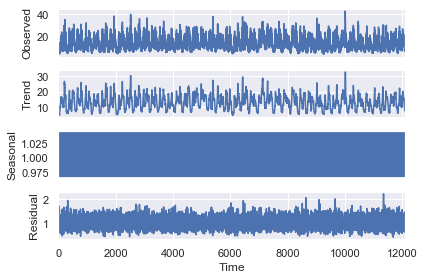

In [14]:
import statsmodels.api as sm
# multiplicative

res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

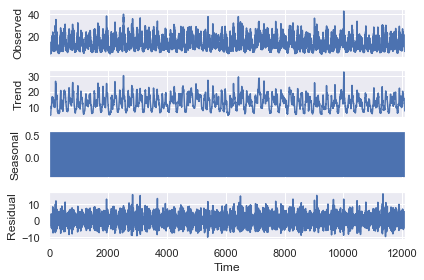

In [15]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()

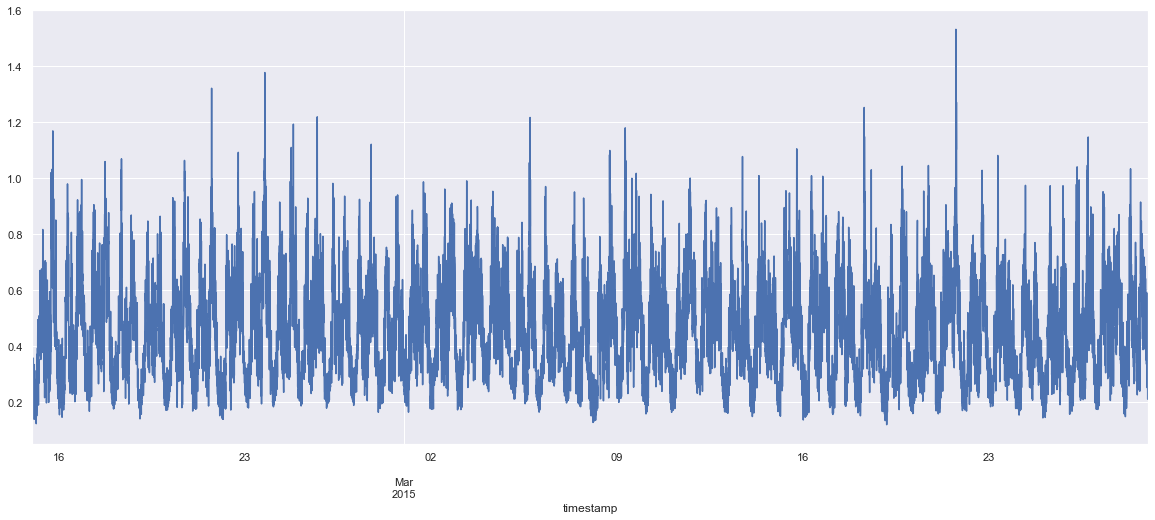

In [17]:
##Outlier Distribution

y_mean_time = train.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

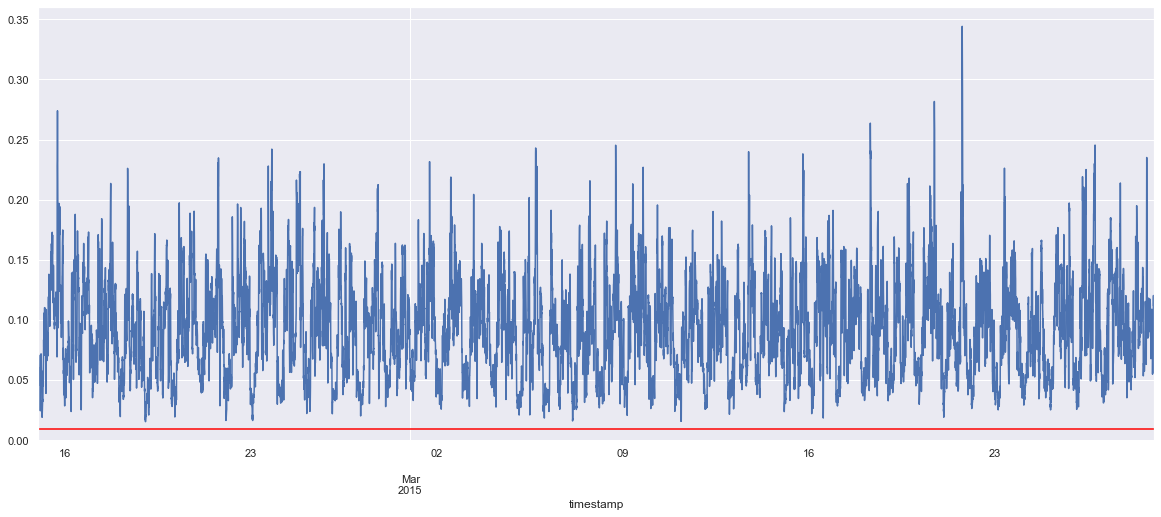

In [18]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
ax = plt.axhline(y=0.009, color='red')

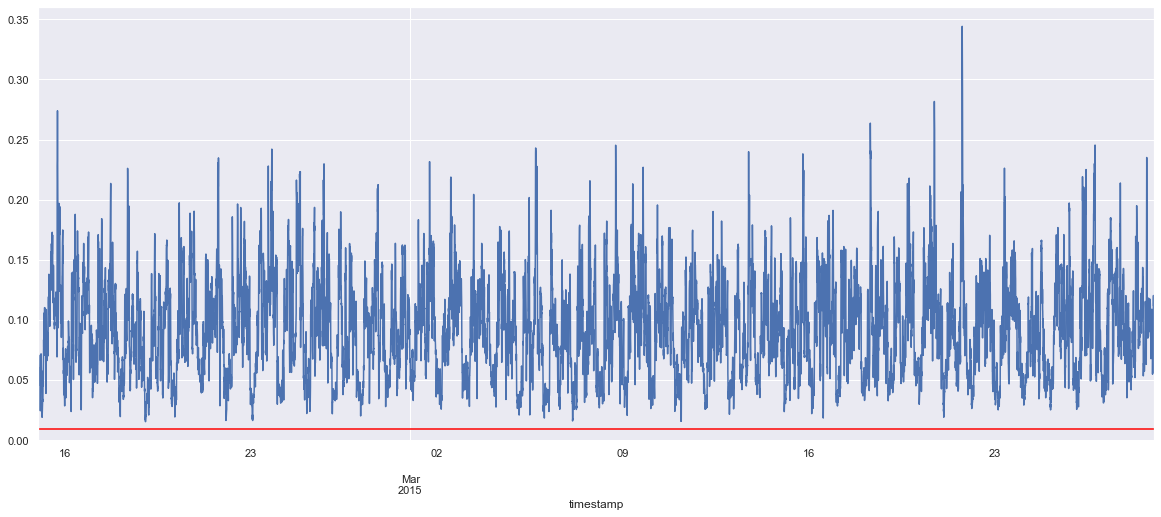

In [19]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color='red')
plt.axvspan(0, 905, color='green', alpha=0.1)
plt.axvspan(906, 1505, color='red', alpha=0.1)

In [20]:
#Group data in a daily basis

#train['meter'] = pd.Categorical(train_['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
daily_train = train.copy()
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'site_id']).sum()
daily_train

meter_reading
date       site_id               
2015-02-15 A01           74.29276
           A02           94.28068
           A03           96.18899
           A04           42.47433
           A07           45.73711
...                           ...
2015-03-29 D16            0.17825
           D20a           0.22770
           D25b           0.18860
           F20            0.00000
           F27            1.34458

[1462 rows x 1 columns]

In [21]:
#Aggregate the data for buildings

daily_train_agg = daily_train.groupby(['date']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2015-02-15,3661.280368,107.684717,"(2015-02-15, B08)",442.868795
1,2015-02-16,3685.356915,108.392850,"(2015-02-16, C26)",575.977385
2,2015-02-17,4112.384519,120.952486,"(2015-02-17, C26)",536.338150
3,2015-02-18,3648.242287,107.301244,"(2015-02-18, C26)",422.116815
4,2015-02-19,3544.442046,104.248295,"(2015-02-19, C26)",444.844265


In [22]:
fig_total = px.line(daily_train_agg, x='date', y='meter_reading-sum', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

In [23]:
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh value per energy aspect')
fig_maximum.show()

## Feature engineering

In [57]:
train['hour'] = train['timestamp'].dt.hour

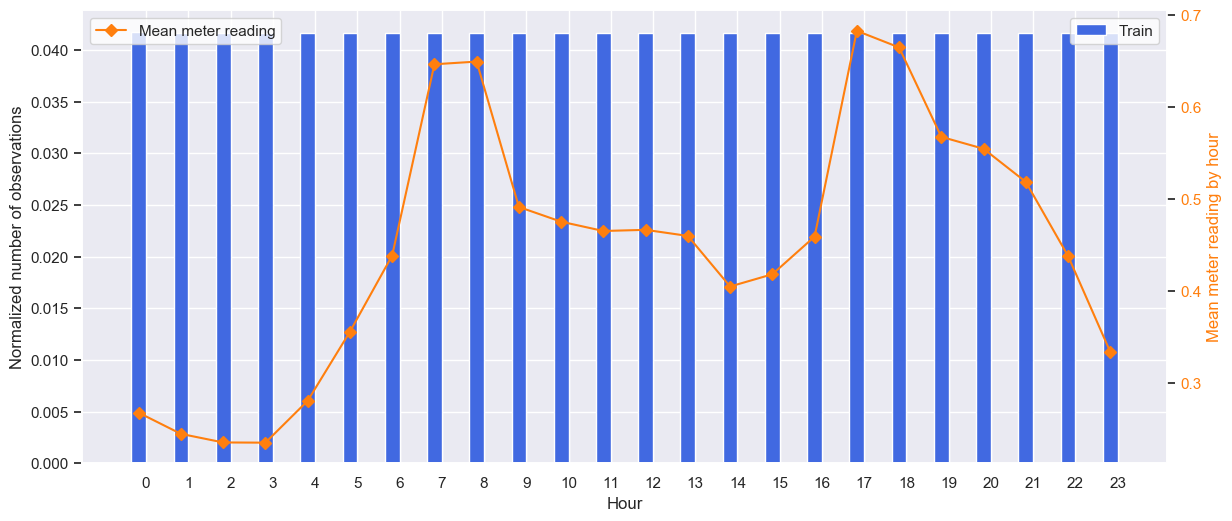

In [68]:
# average meter_reading by hour
train_data = train['hour'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('Hour');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['hour'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['hour', 'meter_reading']].groupby('hour')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by hour', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

In [60]:
train['day'] = train['timestamp'].dt.day

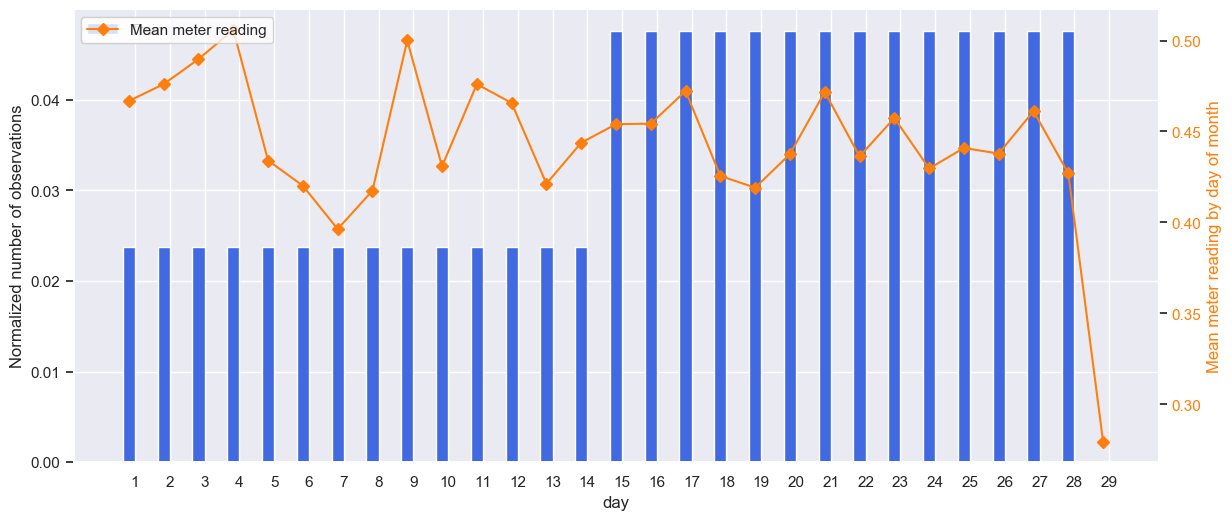

In [61]:
# average meter_reading by day

train_data = train['day'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('day');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['day'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['day', 'meter_reading']].groupby('day')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of month', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

In [62]:
train['weekday'] = train['timestamp'].dt.weekday

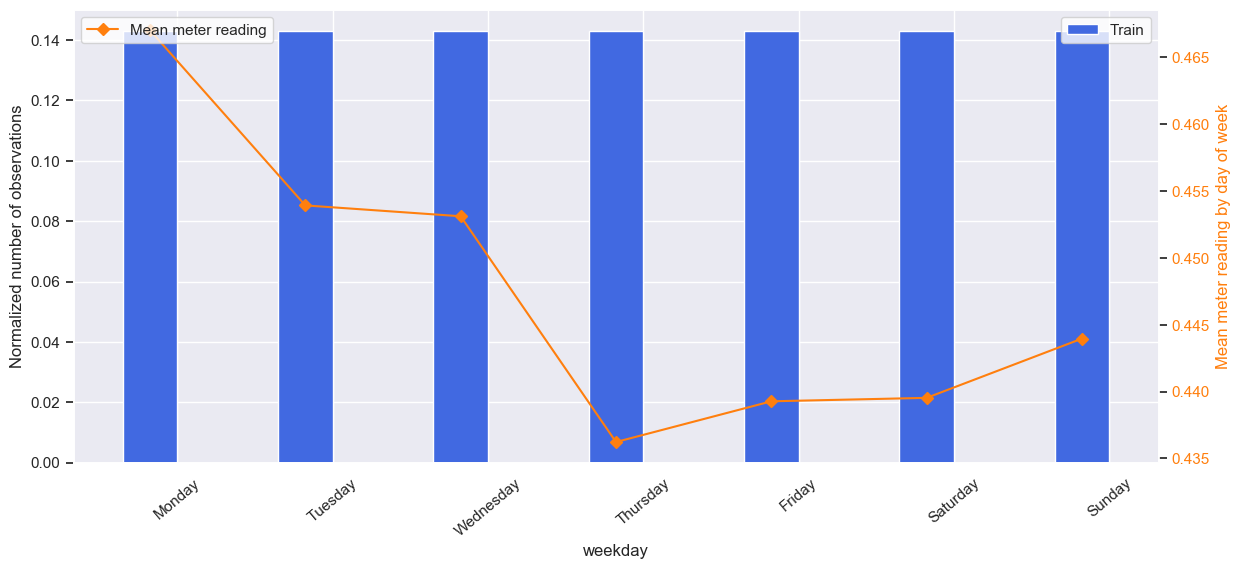

In [63]:
# average meter_reading by day

train_data = train['weekday'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('weekday');
axes.set_xticks(ind + width / 2)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['weekday', 'meter_reading']].groupby('weekday')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by day of week', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

axes.set_xticklabels(train['weekday'].value_counts().sort_index().index.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}), rotation=40);

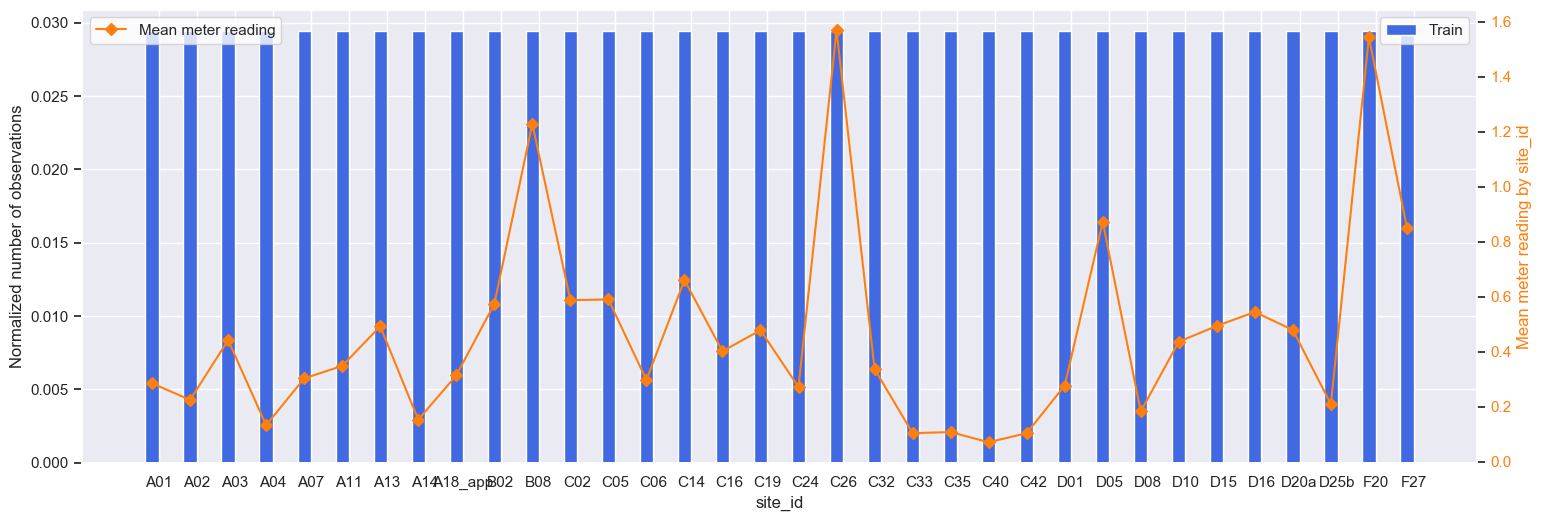

In [65]:
# average meter_reading by site_id

train_data = train['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(18, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr], ['Train'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

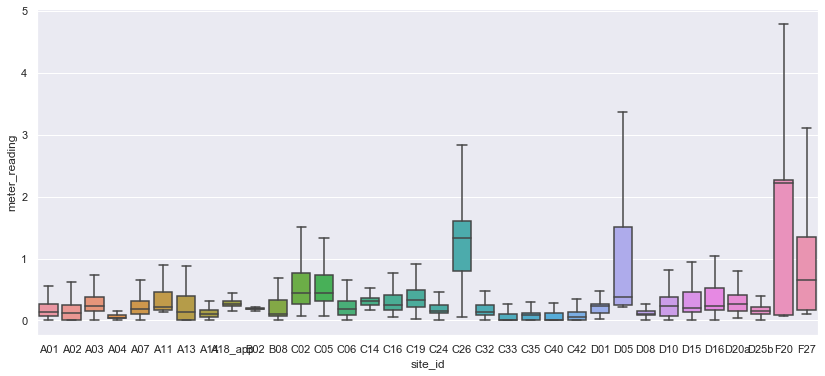

In [66]:
#Box plot of meter_readig by site_id
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train, showfliers=False);

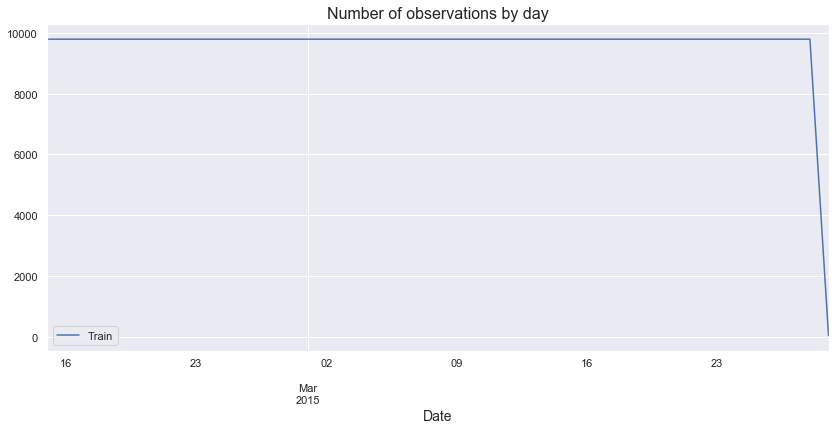

In [67]:
#Number of observations by day
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
#test['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train']);

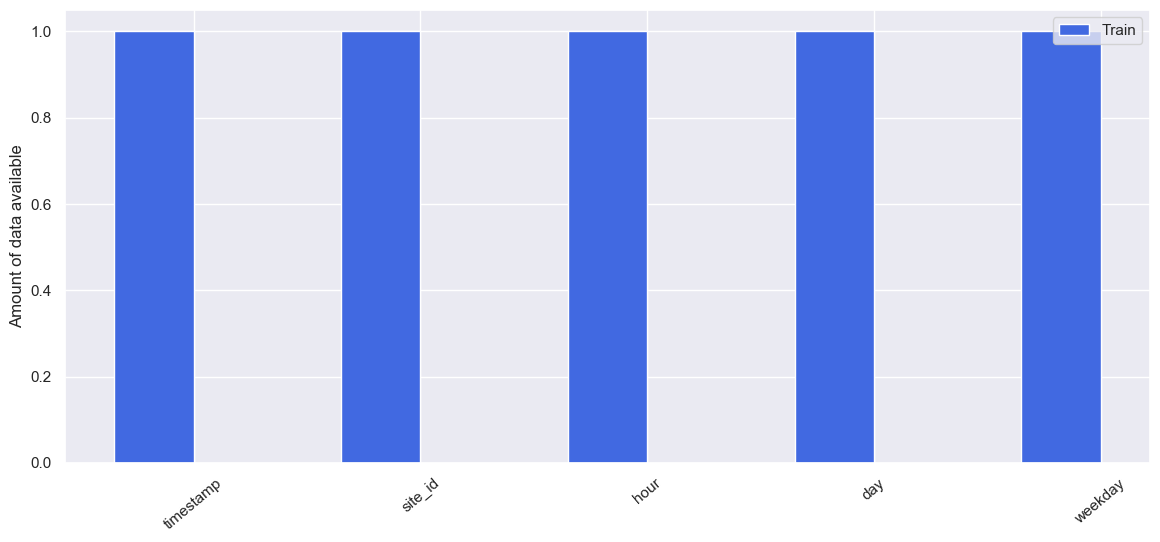

In [69]:
#Amount of data and NaNs

train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr], ['Train']);